# Modèles linéaires


## TP2 Automne 2019 - Détection de discours d'incitation à la haine

##### Membres de l'équipe:

    - MAINKA Adrien (2046374)
    - BAKKAOUI Mehdi (2038803)
    - METAIS Marianne (2038757)

In [13]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import words_repeated_char
import sys
import pickle
import numpy as np

## 1. importation des données (après Preprocessing)

#### Base de données avec 4 classes (0:Hateful, 1:Abusive, 2:Normal et 3:Spam)

In [2]:
file = open("data/preprocess.pkl",'rb')
preprocessed = pickle.load(file) #C'est une "balanced database"  i.e qu'il y autant d'exemples pour chacune des classes.
file.close()

In [8]:
preprocessed.head()

,tweet,label
0,"[i, fuckin, hate, when, nigga, stare, at, me, ...",1
1,"[everyone, jump, to, silly, conclusion, a, soo...",1
2,"[HASHTAG, i, 'm, emo, ., i, need, a, fucking, ...",1
3,"[banana, bread, recipe, :, 1., get, some, brea...",1
4,"[godamn, this, bitch, so, bad, i, want, 2, dri...",1


## 2. Jeu de données

In [6]:
from sklearn.model_selection import train_test_split

X = preprocessed['tweet']
y = preprocessed['label']

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of test set : ", len(test_X))

Length of training set :  72355
Length of test set :  12769


## 3. Classification

In [33]:
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report


def train_evaluate(classifier, training_X, training_Y, validation_X, validation_Y, bowObj, target_names):
    """
    classifier: model used (LogisticRegression...)
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    target_names: names of classes
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """
    
    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    validation_Y_pred = classifier.predict(bowObj.transform(validation_X))
    validationF1score = f1_score(validation_Y, validation_Y_pred,average=None)
    validationPrecision = precision_score(validation_Y, validation_Y_pred,average=None)
    validationRecall = recall_score(validation_Y, validation_Y_pred,average=None)
    
    properties = classification_report(validation_Y, validation_Y_pred, target_names=target_names)

    return classifier, validationPrecision[0], validationRecall[0], validationF1score[0], properties

In [45]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def function(token):
    return token

def model_comparison(classifier, nom_classifier):
    """
    classifier: model used (LogisticRegression...)
    nom_classifier: model name
    
    :return: Comparison of the classifier with CountBoW, TF-IDF, unigram and bigram.
    """
    
    Precision = []
    Recall = []
    F1_score = []
    target_names = ['hateful', 'abusive', 'spam','normal']

    # 1.classifier + CountBoW + unigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier, train_X, train_Y, test_X, test_Y, cv,target_names)
    Precision.append(model[1])
    Recall.append(model[2])
    F1_score.append(model[3])
    print('\033[1m\033[91m'+nom_classifier+' with CountBoW and unigram :'+'\033[0m')
    print(model[4]+'\n')

    # 2.classifier + CountBoW + unigram + bigram
    cv = CountVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,train_X, train_Y, test_X, test_Y, cv,target_names)
    Precision.append(model[1])
    Recall.append(model[2])
    F1_score.append(model[3])
    print('\033[1m\033[91m'+nom_classifier+' with CountBoW, unigram and bigram :'+'\033[0m')
    print(model[4]+'\n')

    # 3.classifier + TF-IDF + unigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,1))
    model=train_evaluate(classifier,train_X, train_Y, test_X, test_Y, tv,target_names)
    Precision.append(model[1])
    Recall.append(model[2])
    F1_score.append(model[3])
    print('\033[1m\033[91m'+nom_classifier+' with TF-IDF and unigram :'+'\033[0m')
    print(model[4]+'\n')

    # 4.classifier + TF-IDF + unigram + bigram
    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=function,
        preprocessor=function,
        token_pattern=None,
        ngram_range=(1,2))
    model=train_evaluate(classifier,train_X, train_Y, test_X, test_Y, tv,target_names)
    Precision.append(model[1])
    Recall.append(model[2])
    F1_score.append(model[3])
    print('\033[1m\033[91m'+nom_classifier+' with TF-IDF, unigram and bigram :'+'\033[0m')
    print(model[4])
    
    # Graphe de comparaison des différents modèles
    
    r=2*np.arange(len(Precision))
    
    Type = ["Precision", "Recall", "F1-Score"]
    models_names = ['CountBoW \nunigram', 'CountBoW \nunigram \nbigram', 
     'TF-IDF \nunigram', 'TF-IDF \nunigram \nbigram']
    bar_width = 0.4

    plt.bar(r-bar_width, Precision,bar_width)
    plt.bar(r, Recall,bar_width)
    plt.bar(r+bar_width, F1_score,bar_width)
    plt.xticks(r, models_names, rotation=0)

    plt.xlabel('Classifier')
    plt.ylabel('Metrics')

    plt.title(nom_classifier)

    plt.legend(Type)

    for i in range(len(Precision)):
        plt.text(x = r[i]-bar_width-bar_width/2 , y = Precision[i]+0.01, s = '%.2f' % Precision[i])
        plt.text(x = r[i]-bar_width/2 , y = Recall[i]+0.01, s = '%.2f' % Recall[i])
        plt.text(x = r[i]+bar_width-bar_width/2 , y = F1_score[i]+0.01, s = '%.2f' % F1_score[i])

    plt.ylim(.2, 1)
    plt.show()

### 4.1 Modèles linéaires

#### 4.1.1 Régression logistique

LogisticRegression with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.37      0.35      0.36       567
     abusive       0.92      0.89      0.90      4488
        spam       0.85      0.85      0.85      6461
      normal       0.48      0.53      0.50      1253

   micro avg       0.81      0.81      0.81     12769
   macro avg       0.65      0.66      0.65     12769
weighted avg       0.81      0.81      0.81     12769


LogisticRegression with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.44      0.27      0.34       567
     abusive       0.91      0.89      0.90      4488
        spam       0.84      0.89      0.86      6461
      normal       0.52      0.48      0.50      1253

   micro avg       0.82      0.82      0.82     12769
   macro avg       0.68      0.63      0.65     12769
weighted avg       0.81      0.82      0.82     12769


LogisticRegression with TF

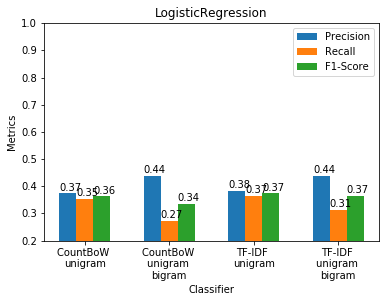

In [46]:
from sklearn.linear_model import LogisticRegression

model_comparison(LogisticRegression(class_weight='balanced'),'LogisticRegression')

#### 4.1.2 Stochastic Gradient Descent

SGDClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.37      0.35      0.36       567
     abusive       0.91      0.90      0.90      4488
        spam       0.85      0.85      0.85      6461
      normal       0.48      0.51      0.50      1253

   micro avg       0.81      0.81      0.81     12769
   macro avg       0.65      0.65      0.65     12769
weighted avg       0.81      0.81      0.81     12769


SGDClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.37      0.35      0.36       567
     abusive       0.92      0.88      0.90      4488
        spam       0.83      0.89      0.86      6461
      normal       0.53      0.43      0.48      1253

   micro avg       0.82      0.82      0.82     12769
   macro avg       0.66      0.64      0.65     12769
weighted avg       0.81      0.82      0.81     12769


SGDClassifier with TF-IDF and unigra

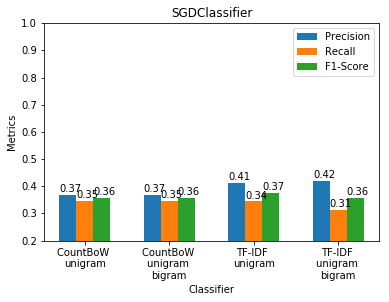

In [47]:
from sklearn.linear_model import SGDClassifier

model_comparison(SGDClassifier(class_weight='balanced'),'SGDClassifier')

#### 4.1.3 Perceptron

Perceptron with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.29      0.28      0.28       567
     abusive       0.72      0.91      0.80      4488
        spam       0.87      0.64      0.74      6461
      normal       0.39      0.56      0.46      1253

   micro avg       0.71      0.71      0.71     12769
   macro avg       0.57      0.60      0.57     12769
weighted avg       0.74      0.71      0.71     12769


Perceptron with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.31      0.35      0.33       567
     abusive       0.91      0.84      0.87      4488
        spam       0.81      0.88      0.84      6461
      normal       0.49      0.39      0.43      1253

   micro avg       0.79      0.79      0.79     12769
   macro avg       0.63      0.61      0.62     12769
weighted avg       0.79      0.79      0.79     12769


Perceptron with TF-IDF and unigram :
     

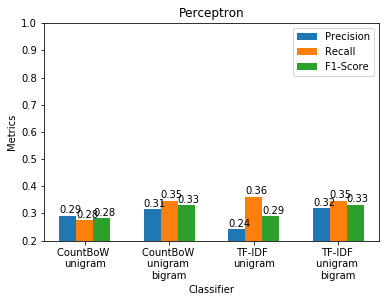

In [48]:
from sklearn.linear_model import Perceptron

model_comparison(Perceptron(class_weight='balanced'),'Perceptron')

#### 4.1.4 PassiveAggressiveClassifier

PassiveAggressiveClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.15      0.53      0.24       567
     abusive       0.92      0.77      0.84      4488
        spam       0.83      0.74      0.78      6461
      normal       0.43      0.45      0.44      1253

   micro avg       0.71      0.71      0.71     12769
   macro avg       0.58      0.62      0.57     12769
weighted avg       0.79      0.71      0.74     12769


PassiveAggressiveClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.26      0.31      0.29       567
     abusive       0.90      0.88      0.89      4488
        spam       0.83      0.85      0.84      6461
      normal       0.49      0.46      0.47      1253

   micro avg       0.80      0.80      0.80     12769
   macro avg       0.62      0.62      0.62     12769
weighted avg       0.80      0.80      0.80     12769


PassiveA

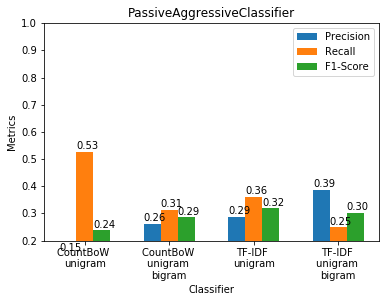

In [49]:
from sklearn.linear_model import PassiveAggressiveClassifier

model_comparison(PassiveAggressiveClassifier(class_weight='balanced'),'PassiveAggressiveClassifier')

### 4.2 Support Vector Machines 

#### 4.2.1  Linear Support Vector Classification

C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Linear Support Vector Classification with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.29      0.32      0.30       567
     abusive       0.90      0.88      0.89      4488
        spam       0.84      0.83      0.83      6461
      normal       0.44      0.47      0.45      1253

   micro avg       0.79      0.79      0.79     12769
   macro avg       0.62      0.62      0.62     12769
weighted avg       0.79      0.79      0.79     12769


Linear Support Vector Classification with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.40      0.23      0.29       567
     abusive       0.90      0.89      0.90      4488
        spam       0.83      0.89      0.86      6461
      normal       0.49      0.43      0.46      1253

   micro avg       0.81      0.81      0.81     12769
   macro avg       0.66      0.61      0.63     12769
weighted avg       0.80      0.81      0.81   

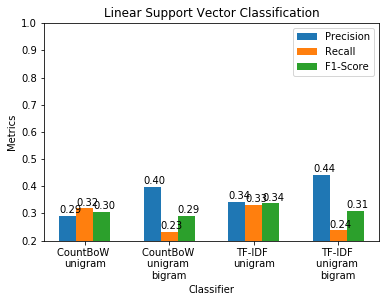

In [50]:
from sklearn.svm import LinearSVC 

model_comparison(LinearSVC(class_weight='balanced'),'Linear Support Vector Classification')

### 4.3 Decision Trees

DecisionTreeClassifier with CountBoW and unigram :
              precision    recall  f1-score   support

     hateful       0.25      0.32      0.28       567
     abusive       0.90      0.85      0.87      4488
        spam       0.83      0.74      0.78      6461
      normal       0.35      0.56      0.43      1253

   micro avg       0.74      0.74      0.74     12769
   macro avg       0.58      0.62      0.59     12769
weighted avg       0.78      0.74      0.76     12769


DecisionTreeClassifier with CountBoW, unigram and bigram :
              precision    recall  f1-score   support

     hateful       0.25      0.32      0.28       567
     abusive       0.90      0.85      0.88      4488
        spam       0.82      0.74      0.78      6461
      normal       0.34      0.55      0.42      1253

   micro avg       0.74      0.74      0.74     12769
   macro avg       0.58      0.61      0.59     12769
weighted avg       0.78      0.74      0.76     12769


DecisionTreeClassi

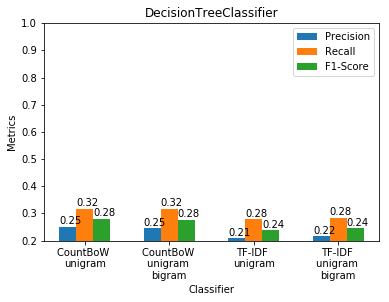

In [51]:
from sklearn.tree import DecisionTreeClassifier

model_comparison(DecisionTreeClassifier(class_weight='balanced'),'DecisionTreeClassifier')